# Regression

<strong>Abstract</strong>  
In this notebook, neural networks will be build for predicting house prices. This is a <strong>regression</strong> example.

<strong>Reference</strong>  
See pages 85-91 of "<strong>Deep Learning with Python</strong>" by Francois Chollet (2018). 

<strong>Summary (page 91)</strong>  
- Regression is done using different loss functions. Mean squared error (MSE) is a loss function commonly used for regression.
- As an evaluation metric, mean absolute error (MAE) can be used.
-  When little training data is available, <strong>K-fold cross-validation</strong> is a powerful method to reliably evaluate a model.
- When little training data is available, it is preferable to use a small network with few hidden layers (typically one or two) in order to avoid overfitting. 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Loading data

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print("train_data shape: {}".format(train_data.shape))
print("train_targets shape: {}".format(train_targets.shape))
print("test_data shape: {}".format(test_data.shape))
print("test_targets shape: {}".format(test_targets.shape))

train_data shape: (404, 13)
train_targets shape: (404,)
test_data shape: (102, 13)
test_targets shape: (102,)


In [ ]:
print("the first 5 train_data: \n{}".format(train_data[:5]))
print("\nthe first 5 train_targets: \n{}".format(train_targets[:5]))

the first 5 train_data: 
[[1.23247e+00 0.00000e+00 8.14000e+00 0.00000e+00 5.38000e-01 6.14200e+00
  9.17000e+01 3.97690e+00 4.00000e+00 3.07000e+02 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 0.00000e+00 4.15000e-01 7.61000e+00
  1.57000e+01 6.27000e+00 2.00000e+00 3.48000e+02 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 0.00000e+00 6.31000e-01 4.97000e+00
  1.00000e+02 1.33250e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.75520e+02
  3.26000e+00]
 [3.96100e-02 0.00000e+00 5.19000e+00 0.00000e+00 5.15000e-01 6.03700e+00
  3.45000e+01 5.98530e+00 5.00000e+00 2.24000e+02 2.02000e+01 3.96900e+02
  8.01000e+00]
 [3.69311e+00 0.00000e+00 1.81000e+01 0.00000e+00 7.13000e-01 6.37600e+00
  8.84000e+01 2.56710e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.91430e+02
  1.46500e+01]]

the first 5 train_targets: 
[15.2 42.3 50.  21.1 17.7]


Let us normalize the data. After this process, you can get data with the mean of 0 and standard deviation of 1.

In [ ]:
mean=train_data.mean(axis=0)
std=train_data.std(axis=0)

train_data=(train_data-mean)/std
test_data=(test_data-mean)/std

## K-fold validation

As can be seen in previous notebooks, a validation dataset is created from a training dataset. In the present case, however, the number of available data is small, which results in a very small validation dataset. As a consequence, the validation scores strongly depend on which data points you chose for validation.   

In order to avoid such situations, K-fold cross-validation method will be used here. In this validation method, the dataset is split into K subsets. One of them is used as a vaidation set, and others (i.e., K-1 subsets) are used for training. You repeat this procedure K times for K different validation sets. The validation score for the model is the average of the K validation scores obtained through the K-fold cross-validation. 

Because the number of samples is small, a very small network with two hidden layers will be used.

In [ ]:
from keras import models
from keras import layers

def build_model():
  model=models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model

Let us define parameters for K-fold cross-validation.

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
print(num_val_samples)

101


In the next cell, the K-fold cross-validation will be implemented, and a model will be trained.

In [ ]:
all_scores= [] # list for saving the final validation MAE value
all_mae_histories = [] # list for saving MAE history

for i in tqdm(range(k)):
  print('processing fold #', i+1)
  val_data = train_data[i * num_val_samples: (i+1)*num_val_samples] # prepare a validation set
  val_targets = train_targets[i * num_val_samples: (i+1)*num_val_samples] # prepare a validation set (target)

  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]],
      axis=0) # prepare a training dataset

  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]],
      axis=0) # prepare a training target

  modelNN = build_model() # build the Keras model (already compiled)

  val_mse, val_mae = modelNN.evaluate(val_data, val_targets, verbose = 0) # get mse and mae scores for the validation set
  all_scores.append(val_mae) # append to the list 

  history = modelNN.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0) # train the model 
  mae_history = history.history['mae'] # get mae history
  all_mae_histories.append(mae_history) # append to the list


  0%|          | 0/4 [00:00<?, ?it/s]

processing fold # 1



 25%|██▌       | 1/4 [03:04<09:14, 184.76s/it]

processing fold # 2



 50%|█████     | 2/4 [06:03<06:06, 183.07s/it]

processing fold # 3



 75%|███████▌  | 3/4 [09:02<03:01, 181.65s/it]

processing fold # 4



100%|██████████| 4/4 [11:56<00:00, 179.10s/it]


In [ ]:
print("The MAE score for the K-fold cross-validation (K=%d): "%k)
print(all_scores)
print("Average MAE score for the validation set: {}".format(np.mean(all_scores)))

The MAE score for the K-fold cross-validation (K=4): 
[21.735557556152344, 22.042360305786133, 21.67760467529297, 24.360260009765625]
Average MAE score for the validation set: 22.453945636749268


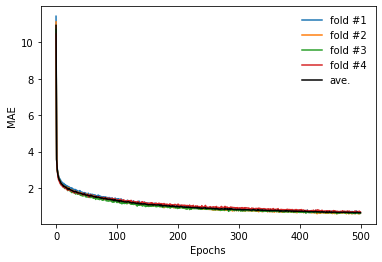

In [ ]:
mae_average=np.zeros_like(all_mae_histories[0])

for i in range(len(all_mae_histories)):
  mae=np.array(all_mae_histories[i])
  plt.plot(mae, label = 'fold #%d'%(i+1) )
  
  mae_average=mae_average + mae/len(all_mae_histories)

plt.plot(mae_average,'k', label='ave.')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()